Calculation of Implied Volatility

In [7]:
"""
name_df เก็บชื่อ stocks ไว้ทั้งหมดที่จะใช้ + ราคา S0, 

เหลือใส่ black scholes เทียยบราคาจาก vol forecast กับ ราคาจริง(จากimplied Vol)
ต้องใช้ S0 (ดึง tvdatafeed ได้)
Strike Price ย้อนสูตร black scholes
"""


'\nname_df เก็บชื่อ stocks ไว้ทั้งหมดที่จะใช้ + ราคา S0, \n\nเหลือใส่ black scholes เทียยบราคาจาก vol forecast กับ ราคาจริง(จากimplied Vol)\nต้องใช้ S0 (ดึง tvdatafeed ได้)\nStrike Price ย้อนสูตร black scholes\n'

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
#in case of dw01

import requests
from bs4 import BeautifulSoup
import pandas as pd
url = 'https://www.blswarrant.com/search'
head = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36'

print('0')

html = requests.get(url, headers={'User-Agent': head}).content
df_list = pd.read_html(html)
df_dw01 = df_list[2]
df_dw01['Stock']='SET:' + df_dw01['DW Symbol'].apply(lambda x: x[:-8])
name_df = pd.DataFrame(df_dw01['Stock'].drop_duplicates())
name_df.reset_index(inplace=True)
name_df = name_df.drop(['index'],axis=1)
name_df

0


,Stock
0,SET:DELTA
1,SET:BH
2,SET:PTTEP
3,SET:KCE
4,SET:TRUE
...,...
77,SET:TLI
78,SET:TOP
79,SET:TTB
80,SET:TU


In [10]:
df_dw01 = df_dw01.drop(['Effective Gearing','Sensitivity','Time Decay','Moneyness','Status','Last Trading Date'],axis=1)
df_dw01

,DW Symbol,Imp.Vol.,TTM (days),Stock
0,DELTA01P2408X,89.13%,65,SET:DELTA
1,BH01C2408A,53.95%,65,SET:BH
2,PTTEP01P2409X,53.74%,86,SET:PTTEP
3,KCE01P2406X,75.79%,25,SET:KCE
4,TRUE01C2408A,64.37%,65,SET:TRUE
...,...,...,...,...
293,VGI01P2405X,76.50%,5,SET:VGI
294,WHA01C2405A,103.06%,5,SET:WHA
295,WHA01C2406A,54.20%,25,SET:WHA
296,WHA01C2408A,55.39%,65,SET:WHA


In [11]:
from tvDatafeed import TvDatafeed, Interval
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

tv = TvDatafeed()
df = tv.get_hist(symbol='SET:SET50', exchange='SET', interval=Interval.in_daily, n_bars=1201)
set50 = df[['close']]
set50.rename(columns = {'close':'remove'}, inplace=True)


you are using nologin method, data you access may be limited


In [12]:
for i in range (name_df.shape[0]):
    df = tv.get_hist(symbol=name_df['Stock'][i], exchange='SET', interval=Interval.in_daily, n_bars=1201)
    df = df[['close']]
    set50 = pd.merge(set50, df, left_index=True, right_index=True, how='outer')
    set50.rename(columns = {'close':name_df['Stock'][i]}, inplace=True)
set50 = set50.drop('remove',axis=1)

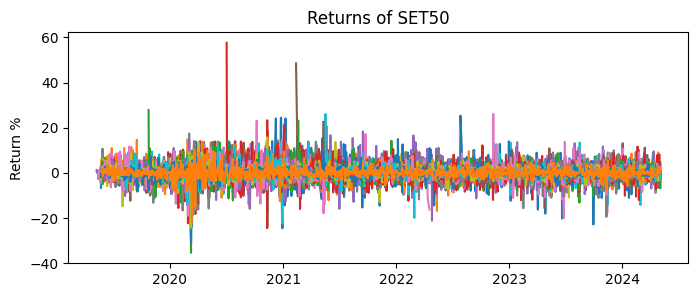

In [13]:
returns = np.log(set50).diff() * 100 #1st difference
plt.figure(figsize=(8,3))
plt.plot(returns)
plt.ylabel("Return %")
plt.title('Returns of SET50');

In [14]:
conclu = name_df[['Stock']]
conclu

,Stock
0,SET:DELTA
1,SET:BH
2,SET:PTTEP
3,SET:KCE
4,SET:TRUE
...,...
77,SET:TLI
78,SET:TOP
79,SET:TTB
80,SET:TU


In [15]:
from arch import arch_model
from sklearn.metrics import mean_squared_error
best_model_list = []
for i in range (name_df.shape[0]):

    returns_individual = returns[[name_df['Stock'][i]]]
    returns_individual = returns_individual.dropna()

    real_vol = []
    for i in range(len(returns)):
        vol = returns_individual[:i].std()
        real_vol.append(vol)

    len_test = int(0.2 * len(returns_individual))
    test_vol = real_vol[-len_test:]

    returns_train, returns_test= returns_individual[:-len_test], returns_individual[-len_test:]

    garch_model_fit = arch_model(returns_train,vol="Garch",p=1,q=1).fit(disp='off',update_freq=len(returns_test))
    arch_model_fit = arch_model(returns_train,vol="ARCH").fit(disp='off',update_freq=len(returns_test))
    gjr_garch_model_fit = arch_model(returns_train,p=1,o=1,q=1).fit(disp='off',update_freq=len(returns_test))
    harch_model_fit = arch_model(returns_train,vol='Harch').fit(disp='off',update_freq=len(returns_test))

    garch_forecast = garch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
    arch_forecast = arch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
    gjr_garch_forecast = gjr_garch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
    harch_forecast = harch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)

    garch = garch_forecast.variance.values[-1,:].flatten()
    arch = arch_forecast.variance.values[-1,:].flatten()
    gjr = gjr_garch_forecast.variance.values[-1,:].flatten()
    harch = harch_forecast.variance.values[-1,:].flatten()

    df_test = returns_test.copy()
    df_test['garch']= np.sqrt(garch)
    df_test['arch']= np.sqrt(arch)
    df_test['gjr']= np.sqrt(gjr)
    df_test['harch']= np.sqrt(harch)
    df_test['Vol'] = np.array(test_vol)

    garch_mae = mean_squared_error(df_test['Vol'],df_test['garch'])
    arch_mae = mean_squared_error(df_test['Vol'],df_test['arch'])
    gjr_garch_mae = mean_squared_error(df_test['Vol'],df_test['gjr'])
    harch_mae = mean_squared_error(df_test['Vol'],df_test['harch'])
    mae = [garch_mae,arch_mae,gjr_garch_mae,harch_mae]
    best = mae.index(min(mae))

    if best == 0:
        mod = 'garch'
    elif best == 1:
        mod = 'arch'
    elif best == 2:
        mod = 'gjr'
    elif best == 3:
        mod = 'harch'
    best_model_list.append(mod)

conclu['Suggested Models'] = np.array(best_model_list)

In [16]:
volatility_list_g = []
volatility_list_a = []
volatility_list_gj = []
volatility_list_h = []
for i in range (len(df_dw01)):
    returns_individual = returns[[df_dw01['Stock'][i]]].dropna()
    forecast_model_fit_g = arch_model(returns_individual,vol="Garch", p=1,q=1).fit(disp='off')
    forecast_model_fit_a = arch_model(returns_individual,vol="ARCH").fit(disp='off')
    forecast_model_fit_gj = arch_model(returns_individual,p=1,o=1,q=1).fit(disp='off')
    forecast_model_fit_h = arch_model(returns_individual,vol="Harch").fit(disp='off')
    forecast_g = forecast_model_fit_g.forecast(horizon=df_dw01['TTM (days)'][i],method='analytic',reindex=True)
    forecast_a = forecast_model_fit_a.forecast(horizon=df_dw01['TTM (days)'][i],method='analytic',reindex=True)
    forecast_gj = forecast_model_fit_gj.forecast(horizon=df_dw01['TTM (days)'][i],method='analytic',reindex=True)
    forecast_h = forecast_model_fit_h.forecast(horizon=df_dw01['TTM (days)'][i],method='analytic',reindex=True)
    
    y = forecast_g.variance.values[-1,:].flatten()
    df_y = pd.DataFrame(y)
    df_y.rename(columns={df_y.columns[0]:'forecast'},inplace=True)
    df_y['forecast'] = np.sqrt(df_y['forecast']) * sqrt(250)
    vol6m = float(df_y['forecast'].tail(1))
    volatility_list_g.append(vol6m)

    y = forecast_a.variance.values[-1,:].flatten()
    df_y = pd.DataFrame(y)
    df_y.rename(columns={df_y.columns[0]:'forecast'},inplace=True)
    df_y['forecast'] = np.sqrt(df_y['forecast']) * sqrt(250)
    vol6m = float(df_y['forecast'].tail(1))
    volatility_list_a.append(vol6m)

    y = forecast_gj.variance.values[-1,:].flatten()
    df_y = pd.DataFrame(y)
    df_y.rename(columns={df_y.columns[0]:'forecast'},inplace=True)
    df_y['forecast'] = np.sqrt(df_y['forecast']) * sqrt(250)
    vol6m = float(df_y['forecast'].tail(1))
    volatility_list_gj.append(vol6m)

    y = forecast_h.variance.values[-1,:].flatten()
    df_y = pd.DataFrame(y)
    df_y.rename(columns={df_y.columns[0]:'forecast'},inplace=True)
    df_y['forecast'] = np.sqrt(df_y['forecast']) * sqrt(250)
    vol6m = float(df_y['forecast'].tail(1))
    volatility_list_h.append(vol6m)
    
df_dw01['Vol_Garch'] = np.array(volatility_list_g)
df_dw01['Vol_Arch'] = np.array(volatility_list_a)
df_dw01['Vol_GJR'] = np.array(volatility_list_gj)
df_dw01['Vol_Harch'] = np.array(volatility_list_h)

In [17]:
summary = pd.merge(df_dw01,conclu,on='Stock')
result = []
for i in range(len(summary)):
    if summary['Suggested Models'][i] == 'garch':
        result.append(summary['Vol_Garch'][i])
    elif summary['Suggested Models'][i] == 'arch':
        result.append(summary['Vol_Arch'][i])
    elif summary['Suggested Models'][i] == 'gjr':
        result.append(summary['Vol_GJR'][i])
    elif summary['Suggested Models'][i] == 'harch':
        result.append(summary['Vol_Harch'][i])

summary['Suggested Model Results'] = np.array(result)
summary['Imp.Vol.'] = summary['Imp.Vol.'].apply(lambda x:x[:-1]).astype(float)

summary['Imp.Vol. - Forecasted Vol.'] = summary['Imp.Vol.'] - summary['Suggested Model Results']
summary


,DW Symbol,Imp.Vol.,TTM (days),Stock,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.
0,DELTA01P2408X,89.13,65,SET:DELTA,69.536588,71.176878,67.327259,71.176431,garch,69.536588,19.593412
1,BH01C2408A,53.95,65,SET:BH,30.955504,30.128607,30.947404,30.128586,harch,30.128586,23.821414
2,PTTEP01P2409X,53.74,86,SET:PTTEP,44.173705,73.312979,41.745083,73.309825,gjr,41.745083,11.994917
3,KCE01P2406X,75.79,25,SET:KCE,40.195767,48.012774,40.510024,48.012955,garch,40.195767,35.594233
4,TRUE01C2408A,64.37,65,SET:TRUE,35.363580,35.389956,35.520625,35.390077,arch,35.389956,28.980044
...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2405X,76.50,5,SET:VGI,47.502217,41.134387,42.105871,41.134437,arch,41.134387,35.365613
294,WHA01C2405A,103.06,5,SET:WHA,24.548886,34.339322,22.976808,34.339580,arch,34.339322,68.720678
295,WHA01C2406A,54.20,25,SET:WHA,26.538784,34.349994,25.162351,34.350252,arch,34.349994,19.850006
296,WHA01C2408A,55.39,65,SET:WHA,29.124928,34.349994,27.918236,34.350252,arch,34.349994,21.040006


In [18]:
#  ต้องเข้าลิงค์แต่ละอันไปเอา strike price https://www.blswarrant.com/mydw/'ชื่อdw'
# หาw,jw
import re
strike = []
ratio = []
for i in range(len(summary)):
    url = 'https://www.blswarrant.com/mydw/' + summary['DW Symbol'][i]
    html = requests.get(url, headers={'User-Agent': head}).content
    soup = BeautifulSoup(html, 'html.parser')
    all_text = soup.get_text()
    pattern = r"Strike \(THB\)\n:\s*([\d,]+\.\d+)"
    match = re.search(pattern, all_text)
    strike_price = match.group(1)
    strike.append(strike_price)

    pattern = r"Ratio \(DW:Underlying\)\n:\s*([\d,]+\.\d+)"
    match = re.search(pattern, all_text)
    rat = match.group(1)
    ratio.append(rat)
summary['Strike'] = np.array(strike)
summary['Ratio'] = np.array(ratio)
summary

,DW Symbol,Imp.Vol.,TTM (days),Stock,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.,Strike,Ratio
0,DELTA01P2408X,89.13,65,SET:DELTA,69.536588,71.176878,67.327259,71.176431,garch,69.536588,19.593412,48.500,4.27873
1,BH01C2408A,53.95,65,SET:BH,30.955504,30.128607,30.947404,30.128586,harch,30.128586,23.821414,280.076,37.09199
2,PTTEP01P2409X,53.74,86,SET:PTTEP,44.173705,73.312979,41.745083,73.309825,gjr,41.745083,11.994917,123.000,9.43507
3,KCE01P2406X,75.79,25,SET:KCE,40.195767,48.012774,40.510024,48.012955,garch,40.195767,35.594233,33.651,5.24659
4,TRUE01C2408A,64.37,65,SET:TRUE,35.363580,35.389956,35.520625,35.390077,arch,35.389956,28.980044,10.500,1.86182
...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2405X,76.50,5,SET:VGI,47.502217,41.134387,42.105871,41.134437,arch,41.134387,35.365613,1.660,0.42023
294,WHA01C2405A,103.06,5,SET:WHA,24.548886,34.339322,22.976808,34.339580,arch,34.339322,68.720678,6.350,1.82044
295,WHA01C2406A,54.20,25,SET:WHA,26.538784,34.349994,25.162351,34.350252,arch,34.349994,19.850006,6.150,0.64256
296,WHA01C2408A,55.39,65,SET:WHA,29.124928,34.349994,27.918236,34.350252,arch,34.349994,21.040006,5.600,0.87392


In [19]:
#ตอนนมี Vol, K, ขาด S0, C,P , rrf
#S0
Spot = []
df_spot = name_df.copy()
for i in range(len(conclu)):
    df = tv.get_hist(symbol=name_df['Stock'][i], exchange='SET', interval=Interval.in_daily, n_bars=2)
    s = df['close'][-1]
    Spot.append(s)
df_spot['S'] = np.array(Spot)
summary = pd.merge(summary,df_spot,on='Stock')
summary

,DW Symbol,Imp.Vol.,TTM (days),Stock,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.,Strike,Ratio,S
0,DELTA01P2408X,89.13,65,SET:DELTA,69.536588,71.176878,67.327259,71.176431,garch,69.536588,19.593412,48.500,4.27873,69.00
1,BH01C2408A,53.95,65,SET:BH,30.955504,30.128607,30.947404,30.128586,harch,30.128586,23.821414,280.076,37.09199,243.00
2,PTTEP01P2409X,53.74,86,SET:PTTEP,44.173705,73.312979,41.745083,73.309825,gjr,41.745083,11.994917,123.000,9.43507,150.50
3,KCE01P2406X,75.79,25,SET:KCE,40.195767,48.012774,40.510024,48.012955,garch,40.195767,35.594233,33.651,5.24659,38.25
4,TRUE01C2408A,64.37,65,SET:TRUE,35.363580,35.389956,35.520625,35.390077,arch,35.389956,28.980044,10.500,1.86182,8.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2405X,76.50,5,SET:VGI,47.502217,41.134387,42.105871,41.134437,arch,41.134387,35.365613,1.660,0.42023,1.77
294,WHA01C2405A,103.06,5,SET:WHA,24.548886,34.339322,22.976808,34.339580,arch,34.339322,68.720678,6.350,1.82044,5.10
295,WHA01C2406A,54.20,25,SET:WHA,26.538784,34.349994,25.162351,34.350252,arch,34.349994,19.850006,6.150,0.64256,5.10
296,WHA01C2408A,55.39,65,SET:WHA,29.124928,34.349994,27.918236,34.350252,arch,34.349994,21.040006,5.600,0.87392,5.10


In [22]:
#c,p
cp_list = []
for i in range(len(summary)):
    df = tv.get_hist(symbol='SET:' + summary['DW Symbol'][i], exchange='SET', interval=Interval.in_daily, n_bars=2)
    cp = df['close'][-1]
    cp_list.append(cp)
summary['Call/Put'] = np.array(cp_list)
summary

,DW Symbol,Imp.Vol.,TTM (days),Stock,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.,Strike,Ratio,S,Call/Put
0,DELTA01P2408X,89.13,65,SET:DELTA,69.536588,71.176878,67.327259,71.176431,garch,69.536588,19.593412,48.500,4.27873,69.00,0.76
1,BH01C2408A,53.95,65,SET:BH,30.955504,30.128607,30.947404,30.128586,harch,30.128586,23.821414,280.076,37.09199,243.00,0.39
2,PTTEP01P2409X,53.74,86,SET:PTTEP,44.173705,73.312979,41.745083,73.309825,gjr,41.745083,11.994917,123.000,9.43507,150.50,0.69
3,KCE01P2406X,75.79,25,SET:KCE,40.195767,48.012774,40.510024,48.012955,garch,40.195767,35.594233,33.651,5.24659,38.25,0.34
4,TRUE01C2408A,64.37,65,SET:TRUE,35.363580,35.389956,35.520625,35.390077,arch,35.389956,28.980044,10.500,1.86182,8.05,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2405X,76.50,5,SET:VGI,47.502217,41.134387,42.105871,41.134437,arch,41.134387,35.365613,1.660,0.42023,1.77,0.09
294,WHA01C2405A,103.06,5,SET:WHA,24.548886,34.339322,22.976808,34.339580,arch,34.339322,68.720678,6.350,1.82044,5.10,0.01
295,WHA01C2406A,54.20,25,SET:WHA,26.538784,34.349994,25.162351,34.350252,arch,34.349994,19.850006,6.150,0.64256,5.10,0.11
296,WHA01C2408A,55.39,65,SET:WHA,29.124928,34.349994,27.918236,34.350252,arch,34.349994,21.040006,5.600,0.87392,5.10,0.42


In [23]:
#use this code to get risk free rate, however, tradingview data is not updated so input rrf manually for now

rf = tv.get_hist(symbol='ECONOMICS:THINTR', exchange='Central Bank',interval=Interval.in_monthly,n_bars=2)
rrf = rf['close'][-1]
rrf = rrf/100


In [24]:
summary['Ratio'] = summary['Ratio'].str.replace(',', '').astype(float)
summary['Strike'] = summary['Strike'].str.replace(',', '').astype(float)

In [25]:
#real cp from imp vol
from scipy.stats import norm
cp_f = []
summary['type'] = summary['DW Symbol'].apply(lambda x: x[-6])
for i in range(len(summary)): #put or call
    d1 = (np.log(summary['S'][i]/summary['Strike'][i]) + ((rrf + (((summary['Imp.Vol.'][i]/100)**2)/2))*(summary['TTM (days)'][i]/365)))/((summary['Imp.Vol.'][i]/100) * np.sqrt(summary['TTM (days)'][i]/365))
    d2 = d1 - ((summary['Imp.Vol.'][i]/100) * np.sqrt(summary['TTM (days)'][i]/365))
    if summary['type'][i] == 'C':
        y = (summary['S'][i] * norm.cdf(d1)) - (summary['Strike'][i] * np.exp(-rrf * (summary['TTM (days)'][i] / 365)) * norm.cdf(d2))
    elif summary['type'][i] == 'P':
        y = (summary['Strike'][i] * np.exp(-rrf * (summary['TTM (days)'][i] / 365)) * norm.cdf(-d2)) - (summary['S'][i] * norm.cdf(-d1))
    y = y / summary['Ratio'][i]
    cp_f.append(y)
summary['Calculated Call/Put'] = np.array(cp_f)
summary

,DW Symbol,Imp.Vol.,TTM (days),Stock,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.,Strike,Ratio,S,Call/Put,type,Calculated Call/Put
0,DELTA01P2408X,89.13,65,SET:DELTA,69.536588,71.176878,67.327259,71.176431,garch,69.536588,19.593412,48.500,4.27873,69.00,0.76,P,0.460201
1,BH01C2408A,53.95,65,SET:BH,30.955504,30.128607,30.947404,30.128586,harch,30.128586,23.821414,280.076,37.09199,243.00,0.39,C,0.266737
2,PTTEP01P2409X,53.74,86,SET:PTTEP,44.173705,73.312979,41.745083,73.309825,gjr,41.745083,11.994917,123.000,9.43507,150.50,0.69,P,0.451679
3,KCE01P2406X,75.79,25,SET:KCE,40.195767,48.012774,40.510024,48.012955,garch,40.195767,35.594233,33.651,5.24659,38.25,0.34,P,0.208438
4,TRUE01C2408A,64.37,65,SET:TRUE,35.363580,35.389956,35.520625,35.390077,arch,35.389956,28.980044,10.500,1.86182,8.05,0.20,C,0.119179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2405X,76.50,5,SET:VGI,47.502217,41.134387,42.105871,41.134437,arch,41.134387,35.365613,1.660,0.42023,1.77,0.09,P,0.050364
294,WHA01C2405A,103.06,5,SET:WHA,24.548886,34.339322,22.976808,34.339580,arch,34.339322,68.720678,6.350,1.82044,5.10,0.01,C,0.005181
295,WHA01C2406A,54.20,25,SET:WHA,26.538784,34.349994,25.162351,34.350252,arch,34.349994,19.850006,6.150,0.64256,5.10,0.11,C,0.055224
296,WHA01C2408A,55.39,65,SET:WHA,29.124928,34.349994,27.918236,34.350252,arch,34.349994,21.040006,5.600,0.87392,5.10,0.42,C,0.336958


In [ ]:
#Black-Scholes
from scipy.stats import norm
cp_f = []
summary['type'] = summary['DW Symbol'].apply(lambda x: x[-6])
for i in range(len(summary)): #put or call
    d1 = (np.log(summary['S'][i]/summary['Strike'][i]) + ((rrf + (((summary['Suggested Model Results'][i]/100)**2)/2))*(summary['TTM (days)'][i]/365)))/((summary['Suggested Model Results'][i]/100) * np.sqrt(summary['TTM (days)'][i]/365))
    d2 = d1 - ((summary['Suggested Model Results'][i]/100) * np.sqrt(summary['TTM (days)'][i]/365))
    if summary['type'][i] == 'C':
        y = (summary['S'][i] * norm.cdf(d1)) - (summary['Strike'][i] * np.exp(-rrf * (summary['TTM (days)'][i] / 365)) * norm.cdf(d2))
    elif summary['type'][i] == 'P':
        y = (summary['Strike'][i] * np.exp(-rrf * (summary['TTM (days)'][i] / 365)) * norm.cdf(-d2)) - (summary['S'][i] * norm.cdf(-d1))
    cp_f.append(y)
summary['Calculated Call/Put'] = np.array(cp_f)
summary

,DW Symbol,Imp.Vol.,TTM (days),Stock,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.,Strike,S,Call/Put,type,Calculated Call/Put,diff
0,DELTA01P2408X,88.67,65,SET:DELTA,69.805766,71.456372,67.597513,71.455887,garch,69.805766,18.864234,48.500,70.00,0.73,P,8.408534e-01,-0.110853
1,BH01C2408A,53.96,65,SET:BH,31.079080,30.248882,31.070947,30.248861,harch,30.248861,23.711139,280.076,244.00,0.40,C,2.539207e+00,-2.139207
2,DELTA01C2409A,80.30,86,SET:DELTA,69.807121,71.456372,67.638702,71.455887,garch,69.807121,10.492879,102.000,70.00,0.53,C,1.965048e+00,-1.435048
3,TRUE01C2408A,63.98,65,SET:TRUE,35.504752,35.531234,35.662424,35.531356,arch,35.531234,28.448766,10.500,8.05,0.20,C,2.262270e-02,0.177377
4,KCE01P2406X,77.37,25,SET:KCE,40.356230,48.204442,40.671742,48.204624,garch,40.356230,37.013770,33.651,38.50,0.33,P,1.761803e-01,0.153820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2408X,80.17,65,SET:VGI,44.930437,41.285490,43.469440,41.285535,arch,41.285490,38.884510,1.290,1.75,0.36,P,3.948244e-03,0.356052
294,WHA01C2405A,103.06,5,SET:WHA,23.793378,34.434346,22.779446,34.434355,arch,34.434346,68.625654,6.350,5.10,0.01,C,1.115263e-09,0.010000
295,WHA01C2406A,54.20,25,SET:WHA,25.994154,34.480016,25.044617,34.480029,arch,34.480016,19.719984,6.150,5.10,0.12,C,3.685655e-03,0.116314
296,WHA01C2408A,54.55,65,SET:WHA,28.831318,34.480016,27.894609,34.480029,arch,34.480016,20.069984,5.600,5.10,0.45,C,1.281138e-01,0.321886


In [ ]:
#Difference
summary['diff'] = summary['Call/Put'] - summary['Calculated Call/Put']
summary

,DW Symbol,Imp.Vol.,TTM (days),Stock,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.,Strike,S,Call/Put,type,Calculated Call/Put,diff
0,DELTA01P2408X,88.67,65,SET:DELTA,69.805766,71.456372,67.597513,71.455887,garch,69.805766,18.864234,48.500,70.00,0.73,P,8.408534e-01,-0.110853
1,BH01C2408A,53.96,65,SET:BH,31.079080,30.248882,31.070947,30.248861,harch,30.248861,23.711139,280.076,244.00,0.40,C,2.539207e+00,-2.139207
2,DELTA01C2409A,80.30,86,SET:DELTA,69.807121,71.456372,67.638702,71.455887,garch,69.807121,10.492879,102.000,70.00,0.53,C,1.965048e+00,-1.435048
3,TRUE01C2408A,63.98,65,SET:TRUE,35.504752,35.531234,35.662424,35.531356,arch,35.531234,28.448766,10.500,8.05,0.20,C,2.262270e-02,0.177377
4,KCE01P2406X,77.37,25,SET:KCE,40.356230,48.204442,40.671742,48.204624,garch,40.356230,37.013770,33.651,38.50,0.33,P,1.761803e-01,0.153820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2408X,80.17,65,SET:VGI,44.930437,41.285490,43.469440,41.285535,arch,41.285490,38.884510,1.290,1.75,0.36,P,3.948244e-03,0.356052
294,WHA01C2405A,103.06,5,SET:WHA,23.793378,34.434346,22.779446,34.434355,arch,34.434346,68.625654,6.350,5.10,0.01,C,1.115263e-09,0.010000
295,WHA01C2406A,54.20,25,SET:WHA,25.994154,34.480016,25.044617,34.480029,arch,34.480016,19.719984,6.150,5.10,0.12,C,3.685655e-03,0.116314
296,WHA01C2408A,54.55,65,SET:WHA,28.831318,34.480016,27.894609,34.480029,arch,34.480016,20.069984,5.600,5.10,0.45,C,1.281138e-01,0.321886


In [ ]:
#summary.to_excel('Summary.xlsx')